# Прогнозирование оттока клиентов оператора связи

## Цель исследования

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Задача**  

Нужно спрогнозировать, уйдёт клиент от оператора связи ближайшее время или нет. Нам предоставлены персональные данные о некоторых клиентах, исторические данные об их поведении и расторжении договоров с оператором связи. Необходимо построить модель со значением метрики AUC-ROC не менее 0.85.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.
Информация о договорах актуальна на 1 февраля 2020

*Целевой признак*

- Факт ухода клиента

## Исследовательский анализ данных

Импортируем все необходимые библиотеки для проведения исследования.

In [1]:
!pip install phik

In [2]:
RANDOM_STATE = 300123

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

Загрузим и изучим данные.

**1) Датафрейм с информацией о договоре.**

In [3]:
try:
    df_contract = pd.read_csv('contract.csv')
except:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [4]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Данный датафрейм должен содержать целевой признак - факт ухода клиента, но в таблице его нет. О факте ухода можно судить по наличию даты окончания договора.

В датафрейме нет пропусков, но потребуется изменить типы данных некоторых столбцов.

In [6]:
df_contract.describe(include='all')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
count,7043,7043,7043,7043,7043,7043,7043.000000,7043
unique,7043,77,5,3,2,4,NaN,6531
top,7590-VHVEG,2014-02-01,No,Month-to-month,Yes,Electronic check,NaN,
freq,1,366,5174,3875,4171,2365,NaN,11
mean,NaN,NaN,NaN,NaN,NaN,NaN,64.761692,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,30.090047,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,18.250000,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,35.500000,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,70.350000,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,89.850000,NaN


In [7]:
df_contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [8]:
df_contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

В данном датасете необходимо будет сформировать целевой признак и новый признак, отражающий сколько времени человек был клиентом компании. Для этого значения `No` в столбце `EndDate` необходимо будет заменить на дату 2020-02-01 - актуальную дату информации о договорах.

**2) Датафрейм с персональными данными клиентов**

In [9]:
try: 
    df_personal = pd.read_csv('personal.csv')
except: 
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
df_personal.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043.000000,7043,7043
unique,7043,2,NaN,2,2
top,7590-VHVEG,Male,NaN,No,No
freq,1,3555,NaN,3641,4933
mean,NaN,NaN,0.162147,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN


In [12]:
df_personal['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [13]:
df_personal['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

В датафоейме также нет пропусков. Потребуется привести значения столбцов `gender`, `Partner` и `Dependents` к бинарному виду и типу *int8*.

**3) Датафрейм с информацией об интернет-услугах**

In [14]:
try: 
    df_internet = pd.read_csv('internet.csv')
except: 
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
    
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [15]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [16]:
df_internet.describe(include='all')

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [17]:
df_internet['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

Данный датафрейм содержит на 1526 объектов меньше, чем датафреймы c информацией о договорах и персональных данных. Возможно, клиенты, не попавшие в этот датафрейм, не использовали услугу Интернет. Этот момент необходимо уточнить у заказчика.

**4) Датафрейм с информацией об услугах телефонии**

In [18]:
try: 
    df_phone = pd.read_csv('phone.csv')
except: 
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
    
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [19]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [20]:
df_phone.describe(include='all')

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Данный датафрейм содержит на 682 объекта меньше, чем датафреймы c информацией о договорах и персональных данных. Возможно, клиенты, не попавшие в этот датафрейм, не использовали Стационарную телефонную связь. Этот момент необходимо уточнить у заказчика.

## План работы

Данная работа состоит из следующих этапов:  
1) Предобработка данных в датасетах:  
- в датафрейме с информацией о договорах изменим тип данных столбцов `BeginDate` и `EndDate` с *object* на *datetime*, а столбца `TotalCharges` c типа *object* на тип *float*, сформируем целевой признак "Exited" и новый признак - сколько времени в днях человек являлся клиентом. Удалим признаки с датами.  


2) Объединение датафреймов и предобработка единого датафрейма:
- сформируем признаки, отражающие пользовался ли клиент услугами интернет и телефонии и удалим незначимые признаки с детализацией каждой услуги
- приведем все бинарные признаки к числовому типу *int*.
- проверим и обработаем пропуски и аномалии
- проведем OHE кодирование признаков для модели логистической регрессии
- проверим выборку на дисбаланс классов и учтём его при обучении моделей
- исследуем мультиколлинеарность признаков

3) Разделим датафрейм на обучающую и тестовую выборки в соотношении 75% / 25% соответственно.

4) Обучим на данных разные модели и найдём лучшую по метрике AUC-ROC используя кросс-валидацию:  
- LogisticRegression
- LGBMClassifier
- CatBoostClassifier

4) Тестирование модели:  
- проведем финальное тестирование лучшей модели на тестовой выборке;  
- исследуем важность признаков и матрицу ошибок для лучшей модели.  

5) Подведем итоги исследования и напишем общий вывод. 

## Предобработка данных

### Датафрейм `contract` с информацией о договорах

Сформируем целевой признак в столбце `Exited` со значениями:  
1 - если клиент ушёл от оператора связи (в столбце `EndDate` присутствует дата окончания договора),  
0 - клиент не ушёл от оператора связи (в столбце `EndDate` значение No)  

In [21]:
df_contract['EndDate'].unique()

array(['No', '2019-12-01 00:00:00', '2019-11-01 00:00:00',
       '2019-10-01 00:00:00', '2020-01-01 00:00:00'], dtype=object)

In [22]:
df_contract['Exited'] = np.where(df_contract['EndDate'] == 'No', 0, 1)

Преобразуем признак `PaperlessBilling` в бинарный формат.

In [23]:
df_contract['PaperlessBilling'] = np.where(df_contract['PaperlessBilling'] == 'No', 0, 1)

Заполним все поля столбца `EndDate` со значением `No` значением `2020-02-01`, то есть клиент не разрывал договор

In [24]:
df_contract['EndDate'] = df_contract['EndDate'].replace('No', '2020-02-01')

Изменим тип данных столбцов `BeginDate` и `EndDate` с object на datetime, а столбца `TotalCharges` c типа *object* на тип *float*

In [25]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])
df_contract['EndDate'] = pd.to_datetime(df_contract['EndDate'])
df_contract['TotalCharges'] = pd.to_numeric(df_contract['TotalCharges'], errors='coerce')
df_contract = df_contract.astype({'PaperlessBilling': 'int8', 'Exited': 'int8'})

В столбце `Duration` создадим новый признак - сколько времени в днях человек являлся клиентом. Затем удалим столбцы `BeginDate` и `EndDate`.

In [26]:
df_contract['Duration'] = df_contract['EndDate'] - df_contract['BeginDate']
df_contract['Days'] = df_contract['Duration'].dt.days.astype('int32')
df_contract = df_contract.drop(['EndDate', 'BeginDate', 'Duration'], axis=1)

Установим столбец `customerID` в качестве индекса, так как он общий для всех четырёх датафреймов

In [27]:
df_contract = df_contract.set_index('customerID')
df_contract.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Days
customerID,,,,,,,
7590-VHVEG,Month-to-month,1,Electronic check,29.85,29.85,0,31
5575-GNVDE,One year,0,Mailed check,56.95,1889.50,0,1036
3668-QPYBK,Month-to-month,1,Mailed check,53.85,108.15,1,61
7795-CFOCW,One year,0,Bank transfer (automatic),42.30,1840.75,0,1371
9237-HQITU,Month-to-month,1,Electronic check,70.70,151.65,1,61


In [28]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   int8   
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   Exited            7043 non-null   int8   
 6   Days              7043 non-null   int32  
dtypes: float64(2), int32(1), int8(2), object(2)
memory usage: 316.4+ KB


### Датафрейм `personal` с персональными данными клиентов

Приведем значения столбцов `gender`, `Partner` и `Dependents` к бинарному виду.

In [29]:
df_personal['gender'] = np.where(df_personal['gender'] == 'Male', 0, 1).astype('int8')
df_personal['Partner'] = np.where(df_personal['Partner'] == 'No', 0, 1).astype('int8')
df_personal['Dependents'] = np.where(df_personal['Dependents'] == 'No', 0, 1).astype('int8')
df_personal['SeniorCitizen'] = df_personal['SeniorCitizen'].astype('int8')

Установим столбец customerID в качестве индекса.

In [30]:
df_personal = df_personal.set_index('customerID')
df_personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,1,0,1,0
5575-GNVDE,0,0,0,0
3668-QPYBK,0,0,0,0
7795-CFOCW,0,0,0,0
9237-HQITU,1,0,0,0


### Датафрейм `internet` с информацией об интернет-услугах

Создадим признак наличия интернет-услуги `isInternetService`. Отстальные малозначимые признаки удалим.

In [31]:
df_internet = df_internet.set_index('customerID')
df_internet['isInternetService'] = 1
df_internet = df_internet['isInternetService']

### Датафрейм `phone` с информацией об услугах телефонии

Создадим признак наличия услуги телефонии `isPhone`. Отстальные малозначимые признаки удалим.

In [32]:
df_phone = df_phone.set_index('customerID')
df_phone['isPhone'] = 1
df_phone = df_phone['isPhone']

### Объединение датафреймов. Предобработка объединенного датафоейма.

Объединим четыре датафрейма в один.

In [33]:
merged_df = df_contract.join([df_personal, df_internet, df_phone])

In [34]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Type               7043 non-null   object 
 1   PaperlessBilling   7043 non-null   int8   
 2   PaymentMethod      7043 non-null   object 
 3   MonthlyCharges     7043 non-null   float64
 4   TotalCharges       7032 non-null   float64
 5   Exited             7043 non-null   int8   
 6   Days               7043 non-null   int32  
 7   gender             7043 non-null   int8   
 8   SeniorCitizen      7043 non-null   int8   
 9   Partner            7043 non-null   int8   
 10  Dependents         7043 non-null   int8   
 11  isInternetService  5517 non-null   float64
 12  isPhone            6361 non-null   float64
dtypes: float64(4), int32(1), int8(6), object(2)
memory usage: 453.9+ KB


Заполним пропуски в столбцаx `isInternetService` и `isPhone` нулями, что будет говорить об отсутствии данных услуг у клиентов

In [35]:
merged_df[['isInternetService', 'isPhone']] = merged_df[['isInternetService', 'isPhone']].fillna(0)
merged_df = merged_df.astype({'isInternetService': 'int8', 'isPhone': 'int8'})

Удалим строки с пропусками в столбце `TotalCharges`, так как у нас нет возможности их заполнить.

In [36]:
merged_df = merged_df.dropna()
merged_df.isna().sum()

Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Exited               0
Days                 0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
isInternetService    0
isPhone              0
dtype: int64

Проверим датафрейм на дубликаты строк.

In [37]:
print(f'В таблице {merged_df.duplicated().sum()} дубликатов строк.')

В таблице 19 дубликатов строк.


Удалим дубликаты строк.

In [38]:
merged_df = merged_df.drop_duplicates()

Проводя исследовательский анализ данных датафреймов по отдельности мы убедились, что неявные дубликаты в столбцах отсутствуют.

Исследуем датафрейм на наличие аномалий и выбросов.

In [39]:
merged_df.describe(include='all')

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Exited,Days,gender,SeniorCitizen,Partner,Dependents,isInternetService,isPhone
count,7013,7013.000000,7013,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000,7013.000000
unique,3,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Month-to-month,NaN,Electronic check,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3856,NaN,2361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,0.593041,NaN,64.879524,2289.392243,0.265364,990.130472,0.495651,0.162698,0.483816,0.299301,0.785113,0.903037
std,NaN,0.491302,NaN,30.064371,2266.812153,0.441558,746.501477,0.500017,0.369116,0.499774,0.457985,0.410773,0.295928
min,NaN,0.000000,NaN,18.250000,18.800000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,0.000000,NaN,35.750000,406.950000,0.000000,276.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
50%,NaN,1.000000,NaN,70.400000,1402.250000,0.000000,883.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
75%,NaN,1.000000,NaN,89.900000,3807.350000,1.000000,1703.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000


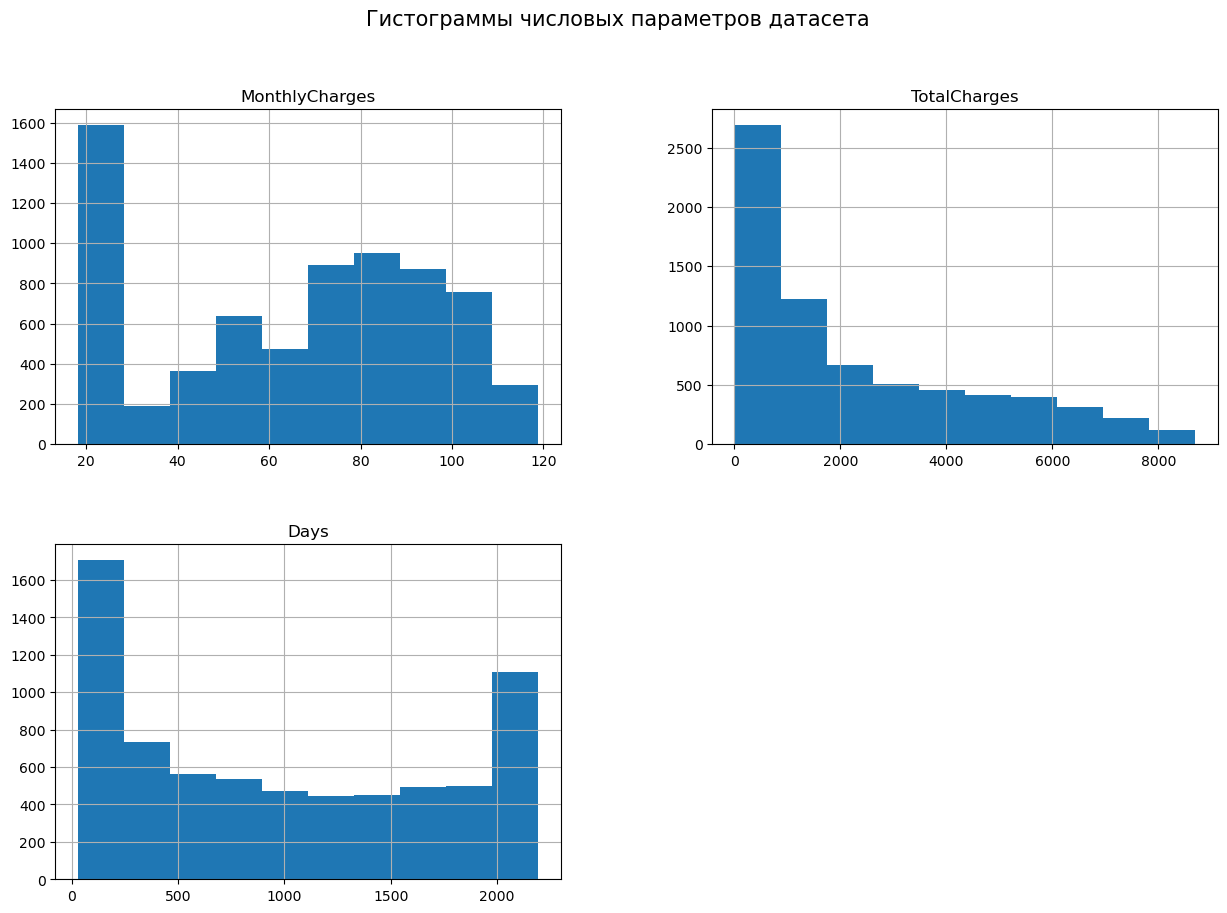

In [40]:
merged_df[['MonthlyCharges', 'TotalCharges', 'Days']].hist(figsize=(15, 10));
plt.suptitle("Гистограммы числовых параметров датасета", fontsize=15);

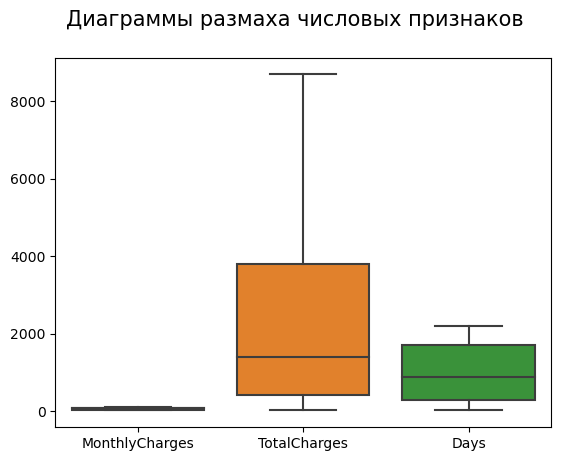

In [41]:
sns.boxplot(data=merged_df[['MonthlyCharges', 'TotalCharges', 'Days']]);
plt.suptitle('Диаграммы размаха числовых признаков', fontsize=15);

Нет аномалий и выбросов числовых значений, требующих обработки.

Посмотрим на дисбаланс классов.

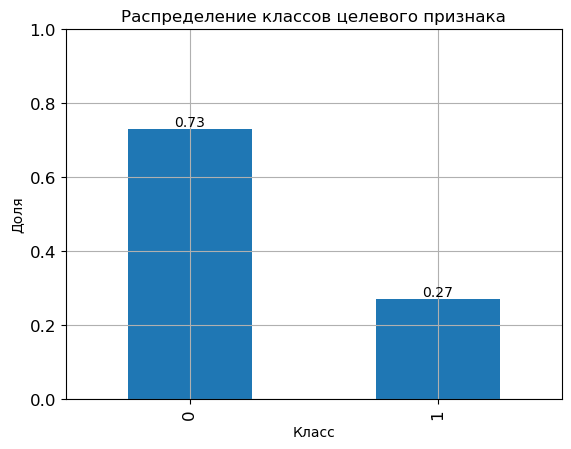

In [42]:
ax = merged_df['Exited'].value_counts(normalize=True).round(2).plot.bar(ylim=(0, 1), 
                                                                        grid=True, 
                                                                        title='Распределение классов целевого признака', 
                                                                        xlabel='Класс', ylabel='Доля', fontsize=12)
ax.bar_label(ax.containers[0], label_type='edge');

Присутствует дисбаланс классов. Учтём это при разбиении на обучающую и тестовую выборки, а также при обучении моделей.

Исследуем выборку на мультиколлинеарность: построим тепловую карту корреляций признаков.

CPU times: total: 922 ms
Wall time: 15min 40s


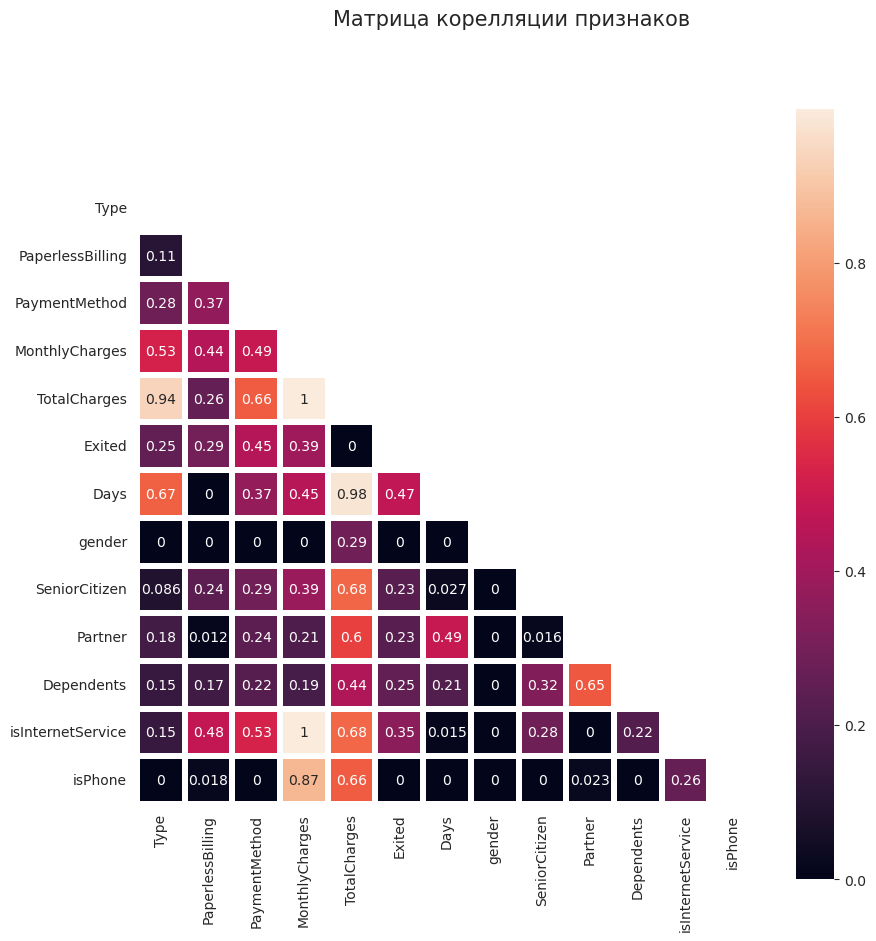

In [43]:
%%time

df_corr = merged_df.phik_matrix(interval_cols=['Days'])
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 10))
    plt.suptitle('Матрица корелляции признаков', fontsize=15);
    ax = sns.heatmap(df_corr, mask=mask, square=True, annot=True, linewidths=3, linecolor='white')

Напишем функцию **get_correl**, которая выведет коррелирующие столбцы и их коэффициент в зависимости от порога корреляции.  
Функция принимает на вход:  
- пороговое значение корреляции,    
- матрицу коэффициентов корреляции признаков  

Функция возвращает: пары коррелирующих признаков и их коэффициент, если он выше порогового.

In [44]:
def get_correl(thresh, cor):
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    all_cor = c1[c1.values != 1]
    return all_cor[abs(all_cor) > thresh]

Выведем пары коррелирующих столбцов для порога 0.80

In [45]:
get_correl(0.8, df_corr)

MonthlyCharges     TotalCharges      0.999992
isInternetService  MonthlyCharges    0.997731
Days               TotalCharges      0.983366
Type               TotalCharges      0.941354
isPhone            MonthlyCharges    0.866657
dtype: float64

Наблюдается сильная корреляция между отображенными признаками. Это может негативно сказаться на качестве линейной модели логистической регресии. Для этой модели признаки `TotalCharges`, `isInternetService`, `isPhone` необходимо будет удалить, чтобы избавиться от мультколлинеарности. Алгоритмы, основанные на деревьях, невосприимчивы к мультиколлинеарности.

### Выводы

В результате проведенной предобработки данных получили следующие результаты:
1) сформировали целевой признак на основе значений столбца `EndDate`  
2) сформировали новые признаки:  
- `Days` - сколько времени в днях человек являлся клиентом оператора услуг связи  
- `isInternetService` - пользовался клиент интернет-услугами или нет
- `isPhone` - пользовался клиент услугами телефонии или нет  

3) удалили малозначимые признаки: `BeginDate`, `EndDate` и признаки с детализацией каждой услуги  
4) преобразовали все бинарные признаки к числовому типу *int8*  
5) объединили все таблицы и провели предобработку объединенного датафрейма: обработали пропуски, проверили на аномалии, удалили 19 дубликатов строк  
6) проверили выборку на дисбаланс классов: дисбаланс классов целевого признака 73% к 27%  
7) исследовали взаимосвязь признаков и обнаружили тесную прямую связь между некоторыми парами признаков. Для модели логистической регресии признаки `TotalCharges`, `isInternetService`, `isPhone` необходимо удалить.

## Подготовка признаков

Разделим выборку на признаки и целевой признак.

In [46]:
features = merged_df.drop('Exited', axis=1)
target = merged_df['Exited'] 

Разделим выборку на обучающую и тестовую в соотношении 75% и 25% соответственно.

In [47]:
# Чтобы количество классов в наборах данных было равномерно распределено, укажем параметр stratify=target.
features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE, 
                                                                            stratify=target)

Осуществим кодирование категориальных признаков для модели логистической регрессии техникой прямого кодирования OHE.

In [48]:
#категориальные признаки для OHE
cat_features = features_train.select_dtypes(include='object').columns.to_list()

features_train_ohe = features_train.copy()
features_test_ohe = features_test.copy()

# удаляем признаки, чтобы избавиться от мультиколлинеарности
features_train_ohe = features_train_ohe.drop(['TotalCharges', 'isInternetService', 'isPhone'], axis=1)
features_test_ohe = features_test_ohe.drop(['TotalCharges', 'isInternetService', 'isPhone'], axis=1)

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train_ohe[cat_features])

# энкодером, который обучен на трениировочной выборке, кодируем выборки
features_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train_ohe[cat_features])
features_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test_ohe[cat_features])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(cat_features, axis=1)
features_test_ohe = features_test_ohe.drop(cat_features, axis=1)

In [49]:
features_train_ohe.head()

,PaperlessBilling,MonthlyCharges,Days,gender,SeniorCitizen,Partner,Dependents,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,
2892-GESUL,0,19.35,549,1,0,1,1,0.0,1.0,0.0,0.0,1.0
2030-BTZRO,1,20.40,184,0,0,1,1,0.0,1.0,1.0,0.0,0.0
3692-JHONH,1,106.50,1584,1,1,1,0,1.0,0.0,0.0,1.0,0.0
6992-TKNYO,0,69.00,1157,0,0,1,0,1.0,0.0,1.0,0.0,0.0
6595-COKXZ,1,44.45,30,1,0,0,0,0.0,0.0,0.0,0.0,1.0


## Обучение моделей

Напишем функцию **get_best_model** для поиска гиперпараметров по сетке GridSearchCV для наилучшей модели по метрике AUC-ROC.  

Функция принимает на вход:  
- модель, 
- гиперпараметры для поиска по сетке GridSearchCV,  
- признаки и целевой признак обучающей выборки.  

Функция возвращает:  
- Метрику AUC-ROC лучшей модели
- Обученную модель с наилучшей метрикой AUC-ROC

In [50]:
def get_best_model(clf, grid_params, model_name, X_train, y_train):
      
    grid = GridSearchCV(estimator=clf, param_grid=grid_params, scoring='roc_auc', cv=3)
    grid.fit(X_train, y_train)
    
    print(f'Гиперпараметры наилучшей модели {model_name}: {grid.best_params_}')
    
    best_roc_auc = grid.best_score_.round(2)
    print(f'Наилучший AUC-ROC {model_name} на кросс-валидации: {best_roc_auc}')
    
    return best_roc_auc, grid.best_estimator_

### LogisticRegression

В выборке для логистической регрессии все признаки численные, так как было применено OHE кодирование. Приведем все признаки к одному масштабу.

In [51]:
scaler = StandardScaler()
scaler.fit(features_train_ohe)
features_train_ohe = scaler.transform(features_train_ohe)
features_test_ohe = scaler.transform(features_test_ohe)

Найдем лучшую модель логистической регрессии.

In [52]:
%%time

clf = LogisticRegression(random_state=RANDOM_STATE)
grid_params = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
               'max_iter': [100, 200],
               'C': range(1, 10),
               'class_weight': ['balanced', None],
               'penalty': ['l1', 'l2', 'elasticnet', None],
               'tol': [0.0001, 0.001]}

LR_AUC_ROC_cv, LR_best_model = get_best_model(clf, grid_params, 'LogisticRegression', features_train_ohe, target_train)

Гиперпараметры наилучшей модели LogisticRegression: {'C': 1, 'class_weight': None, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Наилучший AUC-ROC LogisticRegression на кросс-валидации: 0.83
CPU times: total: 1min 8s
Wall time: 29.9 s


### CatBoostClassifier

Найдем лучшую модель CatBoostClassifier с учётом дисбаланса классов.

In [53]:
%%time

clf_cb = CatBoostClassifier(eval_metric='AUC', loss_function='Logloss', logging_level='Silent', iterations=500,
                            auto_class_weights='Balanced', random_state=RANDOM_STATE)
pool_train = Pool(features_train, label=target_train, cat_features=cat_features)

grid_params = {'learning_rate': [0.1, 0.3, 0.5],
               'depth': range(2, 10, 2),
               'l2_leaf_reg': range(2, 10, 2)}

catboost_grid = clf_cb.grid_search(grid_params,
                                   X=pool_train,
                                   verbose=False,
                                   plot=False)

print(f"Гиперпараметры наилучшей модели CatBoostRegressor: {catboost_grid['params']}")
CB_AUC_ROC_cv = np.mean(catboost_grid['cv_results']['test-AUC-mean']).round(2)
print(f'Наилучший AUC-ROC CatBoostRegressor: {CB_AUC_ROC_cv}')

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate

Замерим время обучения и предсказания лучшей модели на тренировочной выборке.

In [54]:
%%time

model = CatBoostClassifier(eval_metric='AUC', 
                           loss_function='Logloss', 
                           logging_level='Silent', 
                           iterations=500,
                           auto_class_weights='Balanced', 
                           depth=2, 
                           l2_leaf_reg=2, 
                           learning_rate=0.5, 
                           random_state=RANDOM_STATE)
model.fit(features_train, target_train, cat_features=cat_features, verbose=False)

CPU times: total: 3.72 s
Wall time: 8.81 s


In [55]:
%%time

print(f'AUC-ROC модели CatBoostClassifier на обучающей выборке: {roc_auc_score(target_train, model.predict_proba(features_train)[:, 1])}')

AUC-ROC модели CatBoostClassifier на обучающей выборке: 0.9745910619224187
CPU times: total: 0 ns
Wall time: 28.9 ms


### LGBMClassifier

Найдем лучшую модель LGBMClassifier.

In [56]:
%%time

#объявим категориальные признаки
features_train.loc[:, cat_features] = features_train.loc[:, cat_features].astype('category')

clf = LGBMClassifier(silent=True, random_state=RANDOM_STATE)
grid_params = {'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
               'max_depth': range(2, 10, 2),
               'n_estimators': [50, 100, 200, 500, 1000],
               'learning_rate': [0.1, 0.3, 0.5],
               'importance_type': ['split', 'gain']}

LGMB_AUC_ROC_cv, LGMB_best_model = get_best_model(clf, grid_params, 'LGBMClassifier', features_train, target_train)

Гиперпараметры наилучшей модели LGBMClassifier: {'boosting_type': 'gbdt', 'importance_type': 'split', 'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 1000}
Наилучший AUC-ROC LGBMClassifier на кросс-валидации: 0.91
CPU times: total: 37min 37s
Wall time: 5min 50s


Замерим время обучения и предсказания лучшей модели на тренировочной выборке.

In [57]:
%%time

model = LGBMClassifier(silent=True, 
                       random_state=RANDOM_STATE, 
                       boosting_type='gbdt', 
                       importance_type='split', 
                       learning_rate='0.3',
                       max_depth=2,
                       n_estimators=1000)
model.fit(features_train, target_train)

CPU times: total: 1.12 s
Wall time: 199 ms


LGBMClassifier(learning_rate='0.3', max_depth=2, n_estimators=1000,
               random_state=300123)

In [58]:
%%time

print(f'AUC-ROC модели LGBMClassifier на обучающей выборке: {roc_auc_score(target_train, model.predict_proba(features_train)[:, 1])}')

AUC-ROC модели LGBMClassifier на обучающей выборке: 0.9786859130076168
CPU times: total: 266 ms
Wall time: 47.1 ms


## Анализ моделей

Сведем все значения метрик качества моделей в таблицу.

In [68]:
index = ['LogisitcRegression', 'CatBoostClassifier', 'LGBMClassifier']
data = {'Метрика AUC-ROC на обучающей выборке':[LR_AUC_ROC_cv,
                                                CB_AUC_ROC_cv,
                                                LGMB_AUC_ROC_cv],
        'Время предсказания(ms)':['-',
                                  28.9,
                                  47.1]
       }

pd.DataFrame(data=data, index=index).sort_values(by='Метрика AUC-ROC на обучающей выборке', ascending=False)

,Метрика AUC-ROC на обучающей выборке,Время предсказания(ms)
CatBoostClassifier,0.91,28.9
LGBMClassifier,0.91,47.1
LogisitcRegression,0.83,-


Модели CatBoostClassifier и LGBMClassifier показали одинаковый результат по метрике AUC-ROC на тренировочной выборке, но модель CatBoostClassifier превосходит по времени предсказания в два раза. Наилучшей моделью на тренировочной выборке является CatBoostClassifier.

## Тестирование

Лучшей моделью на кросс-валидации оказалась модель CatBoostClassifier с гиперпараметрами:  
**{loss_function='Logloss', iterations=500, auto_class_weights='Balanced', 'depth': 2, 'l2_leaf_reg': 2, 'learning_rate': 0.5}**    
Проверим качество лучшей модели на тестовой выборке, выведем матрицу ошибок и исследуем важность признаков.

In [69]:
predictions_cb = clf_cb.predict(features_test)
proba_one_cb = clf_cb.predict_proba(features_test)[:, 1]

data = {'CatBoostClassifier': 
              [
                  accuracy_score(target_test, predictions_cb).round(2),
                  recall_score(target_test, predictions_cb).round(2),
                  precision_score(target_test, predictions_cb).round(2),
                  f1_score(target_test, predictions_cb).round(2),
                  roc_auc_score(target_test, proba_one_cb).round(2)
              ]
       }
index=['Accuracy', 'Recall', 'Precision', 'F1', 'ROC-AUC']
pd.DataFrame(data=data, index=index)

,CatBoostClassifier
Accuracy,0.87
Recall,0.79
Precision,0.73
F1,0.76
ROC-AUC,0.93


Матрица ошибок CatBoostClassifier на тестовой выборке:


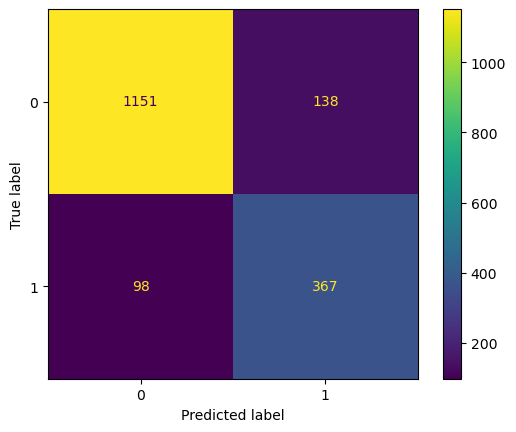

In [70]:
print('Матрица ошибок CatBoostClassifier на тестовой выборке:')
cm = confusion_matrix(target_test, predictions_cb, labels=clf_cb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_cb.classes_)
disp.plot();

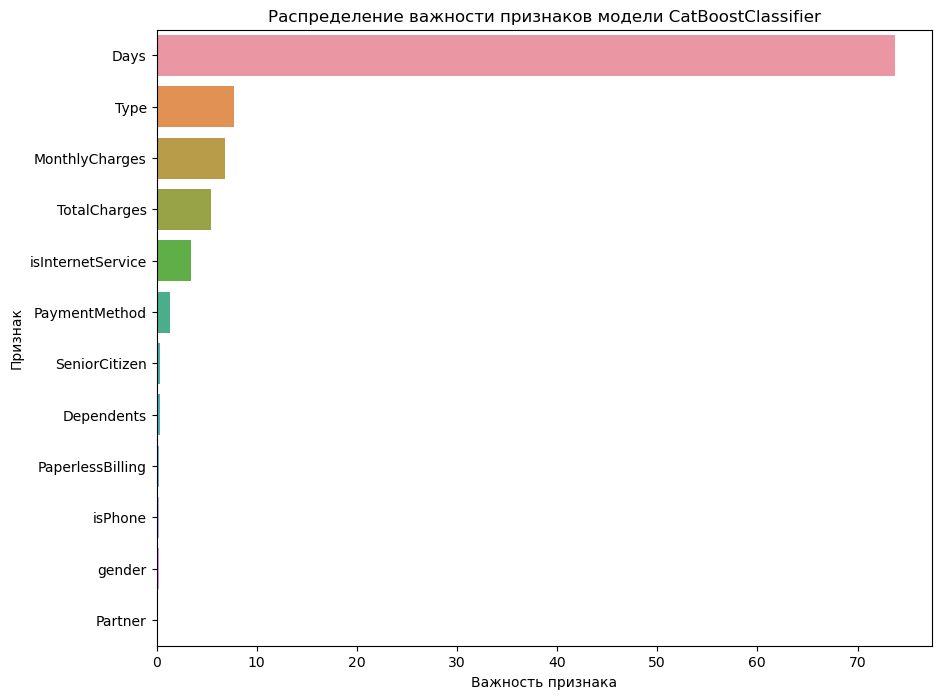

In [71]:
feature_importance = np.array(clf_cb.get_feature_importance())
feature_names = np.array(features_train.columns)
data={'feature_names':feature_names,'feature_importance':feature_importance}
fi_df = pd.DataFrame(data)
fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
plt.figure(figsize=(10,8))
sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
plt.title('Распределение важности признаков модели CatBoostClassifier')
plt.xlabel('Важность признака')
plt.ylabel('Признак');

**Выводы**  
- AUC-ROC на тестовой выборке - 0.93  
- 367 истинноположительных, 98 ложноотрицательных (Recall = 0.79) и 138 ложноположительных предсказаний (Precision = 0.73)  
- 5 наиболее важных признаков для модели CatBoostClassifier:  

1) `Days` - чем дольше человек является клиентом компании, тем меньше вероятность, что он уйдёт  

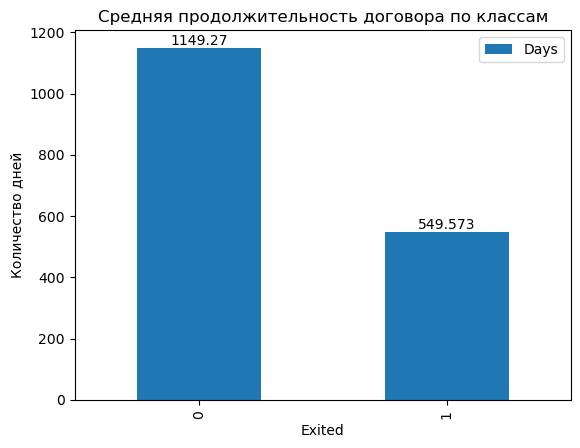

In [72]:
ax = merged_df.pivot_table(index='Exited', values='Days', aggfunc='mean').plot(kind='bar', 
                                                                               title='Средняя продолжительность договора по классам', 
                                                                               ylabel='Количество дней')
ax.bar_label(ax.containers[0], label_type='edge');

2) `Type`- клиенты, которые оплачивают услуги сразу за год или за два практически не уходят

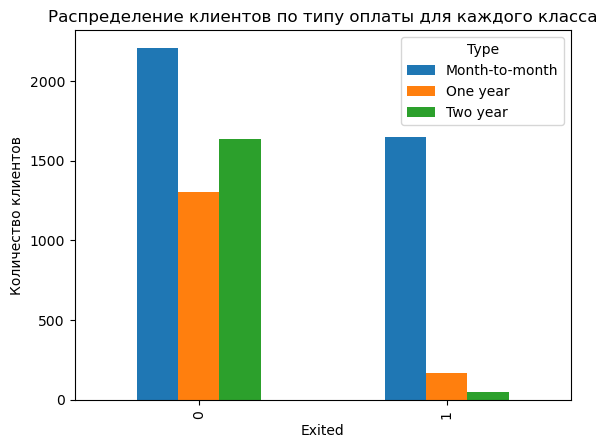

In [73]:
merged_df.pivot_table(index='Exited', columns='Type', values='Days', aggfunc='count').plot(kind='bar', 
                                                                                           title='Распределение клиентов по типу оплаты для каждого класса',
                                                                                           ylabel='Количество клиентов');

3) `MonthlyCharges`- средний чек за месяц ушедших клиентов выше.

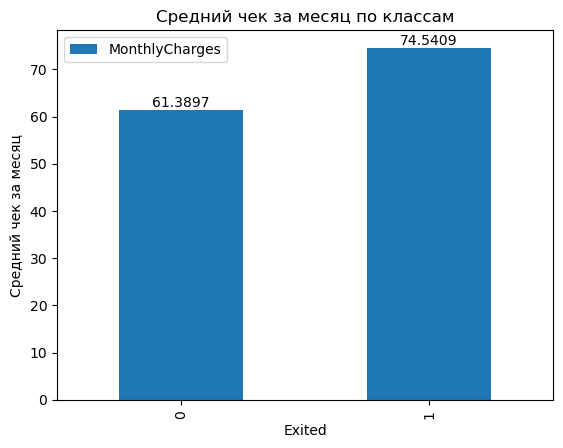

In [74]:
ax = merged_df.pivot_table(index='Exited', values='MonthlyCharges', aggfunc='mean').plot(kind='bar', 
                                                                                         title='Средний чек за месяц по классам', 
                                                                                         ylabel='Средний чек за месяц')
ax.bar_label(ax.containers[0], label_type='edge');

4) `TotalCharges`- здесь тоже логично, если человек остался клиентом, он продолжает платить и его общий чек больше, чем у ушедшего клиента.

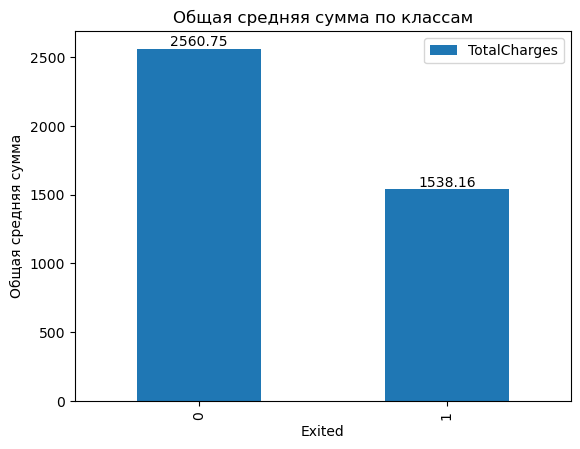

In [75]:
ax = merged_df.pivot_table(index='Exited', values='TotalCharges', aggfunc='mean').plot(kind='bar', 
                                                                                       title='Общая средняя сумма по классам', 
                                                                                       ylabel='Общая средняя сумма')
ax.bar_label(ax.containers[0], label_type='edge');

5) `isInternetService`- уходят в основном клиенты с подключенной услугой интернета.

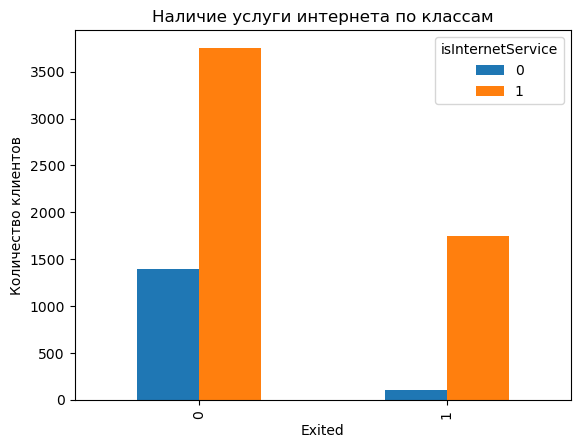

In [76]:
ax = merged_df.pivot_table(index='Exited', columns='isInternetService', values='Days', aggfunc='count').plot(kind='bar', 
                                                                                                             title='Наличие услуги интернета по классам', 
                                                                                                             ylabel='Количество клиентов')

## Общий вывод

В данной работе были исследованы модели, способные проанализировать поведение клиентов оператора связи на имеющихся данных и спрогнозировать, уйдёт клиент от оператора или нет, то есть решить задачу классификации.  

Исходные данные были предоставлены в четырёх датасетах. В результате проведенной предобработки данные были подготовлены для дальнейшего обучения моделей следующим образом:  

1) сформировали целевой признак на основе значений столбца EndDate: факт ухода клиента (ушёл — 1, не ушёл — 0)  
2) сформировали новые признаки:  
`Days` - сколько времени в днях человек являлся клиентом оператора услуг связи    
`isInternetService` - пользовался клиент интернет-услугами или нет  
`isPhone` - пользовался клиент услугами телефонии или нет  
3) удалили малозначимые признаки: `BeginDate`, `EndDate` и признаки с детализацией каждой услуги    
4) преобразовали все бинарные признаки к числовому типу int8   
5) объединили все таблицы и провели предобработку объединенного датафрейма: обработали пропуски, проверили на аномалии, удалили 19 дубликатов строк. В результате получили датасет, состоящий из 7013 строк и 13 признаков (включая целевой)    
6) проверили выборку на дисбаланс классов: дисбаланс классов целевого признака 0 - 73%, 1 - 27%   
7) исследовали взаимосвязь признаков и обнаружили тесную прямую связь между некоторыми парами признаков. Для модели логистической регресии признаки `TotalCharges`, `isInternetService`, `isPhone необходимо удалить` были удалены, чтобы избежать мультиколлинеарности    
8) разделили выборку на обучающую и тестовую в соотношении 75% к 25% соответственно   
9) для модели LogisticRegression категориальные признаки `Type` и `PaymentMethod` были преобразованы в численные техникой OHE, а признаки `TotalCharges`, `isInternetService`, `isPhone` удалены из-за тесной взаимосвязи.    

Далее для моделей LogisticRegression, LGBMClassifier и CatBoostClassifier были подобраны гиперпараметры, чтобы получить модели с наилучшей метрикой AUC-ROC на кросс-валидации. Модели CatBoostClassifier и LGBMClassifier показали одинаковый результат на тренировочной выборке, но CatBoostClassifier имеет лучший показатель по времени предсказания.  

В результате получили следующую итоговую модель: CatBoostClassifier c гиперпараметрами 
```
{loss_function='Logloss', iterations=500, 'depth': 2, 'l2_leaf_reg': 2, 
'learning_rate': 0.5, auto_class_weights='Balanced', random_state=300123}
```
Метрики качества на тестовой выборке:   
- **ROC-AUC:	    0.93**     
- Accuracy:	    0.87  
- Recall:	    0.79  
- Precision:	0.73  
- F1:	        0.76  

Наиболее важными признаками для решения задачи оказались:
- `Days` - сколько времени в днях человек являлся клиентом оператора услуг связи  
- `Type` - как человек оплачивает: помесячно, за год или за два года  
- `MothlyCharge`, `TotalCharge`, `isInternetService`.